## Summative Lab: Forest Fires Prevention

### Step 1: Load the Dataset

*   Install and import the ucimlrepo library.
*   Load the Forest Fires dataset:
 *   Predictors: Features from forest_fires.data.features.
 *   Target: forest_fires.data.targets.

In [73]:
# Run pip install if necessary to access the UCI ML Repository (uncomment the next line)
#! pip install ucimlrepo

In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [75]:
# Data
from ucimlrepo import fetch_ucirepo


forest_fires = fetch_ucirepo(id=162)
X = forest_fires.data.features
y = forest_fires.data.targets.squeeze()


# Display dataset structure
print(X.info())
print(X.describe())
print(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 48.6+ KB
None
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192 

### Step 2: EDA

* Examine the dataset structure and summary statistics.
* Analyze correlations between predictors and the target variable.
* Plot scatterplots for key predictors vs. the target.
* Generate a residual plot to check for randomness in residuals.

In [76]:
# 1. Examine dataset structure
# Check for missing values
print(X.isnull().sum())

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
dtype: int64


In [78]:
# Encode categoricals
X_encoded = pd.get_dummies(X, columns=['month', 'day'], drop_first=True)

In [80]:
# Transform skewed target
y_log = np.log1p(y_1d)   # log(area + 1)

In [81]:
corr_matrix = X_encoded.copy()
corr_matrix['target'] = y
correlations = corr_matrix.corr()
print("Top correlations with target:")
print(correlations['target'].sort_values(ascending=False))

Top correlations with target:
target       1.000000
temp         0.097844
day_sat      0.087868
DMC          0.072994
X            0.063385
month_sep    0.056573
DC           0.049383
Y            0.044873
FFMC         0.040122
day_thu      0.020121
wind         0.012317
ISI          0.008258
month_may    0.006264
month_jul    0.006149
month_dec    0.001010
day_tue     -0.001333
month_aug   -0.004187
rain        -0.007366
month_nov   -0.008893
day_wed     -0.011452
month_jan   -0.012589
month_oct   -0.016878
month_jun   -0.020314
day_sun     -0.020463
month_feb   -0.020732
day_mon     -0.021206
month_mar   -0.045596
RH          -0.075519
Name: target, dtype: float64


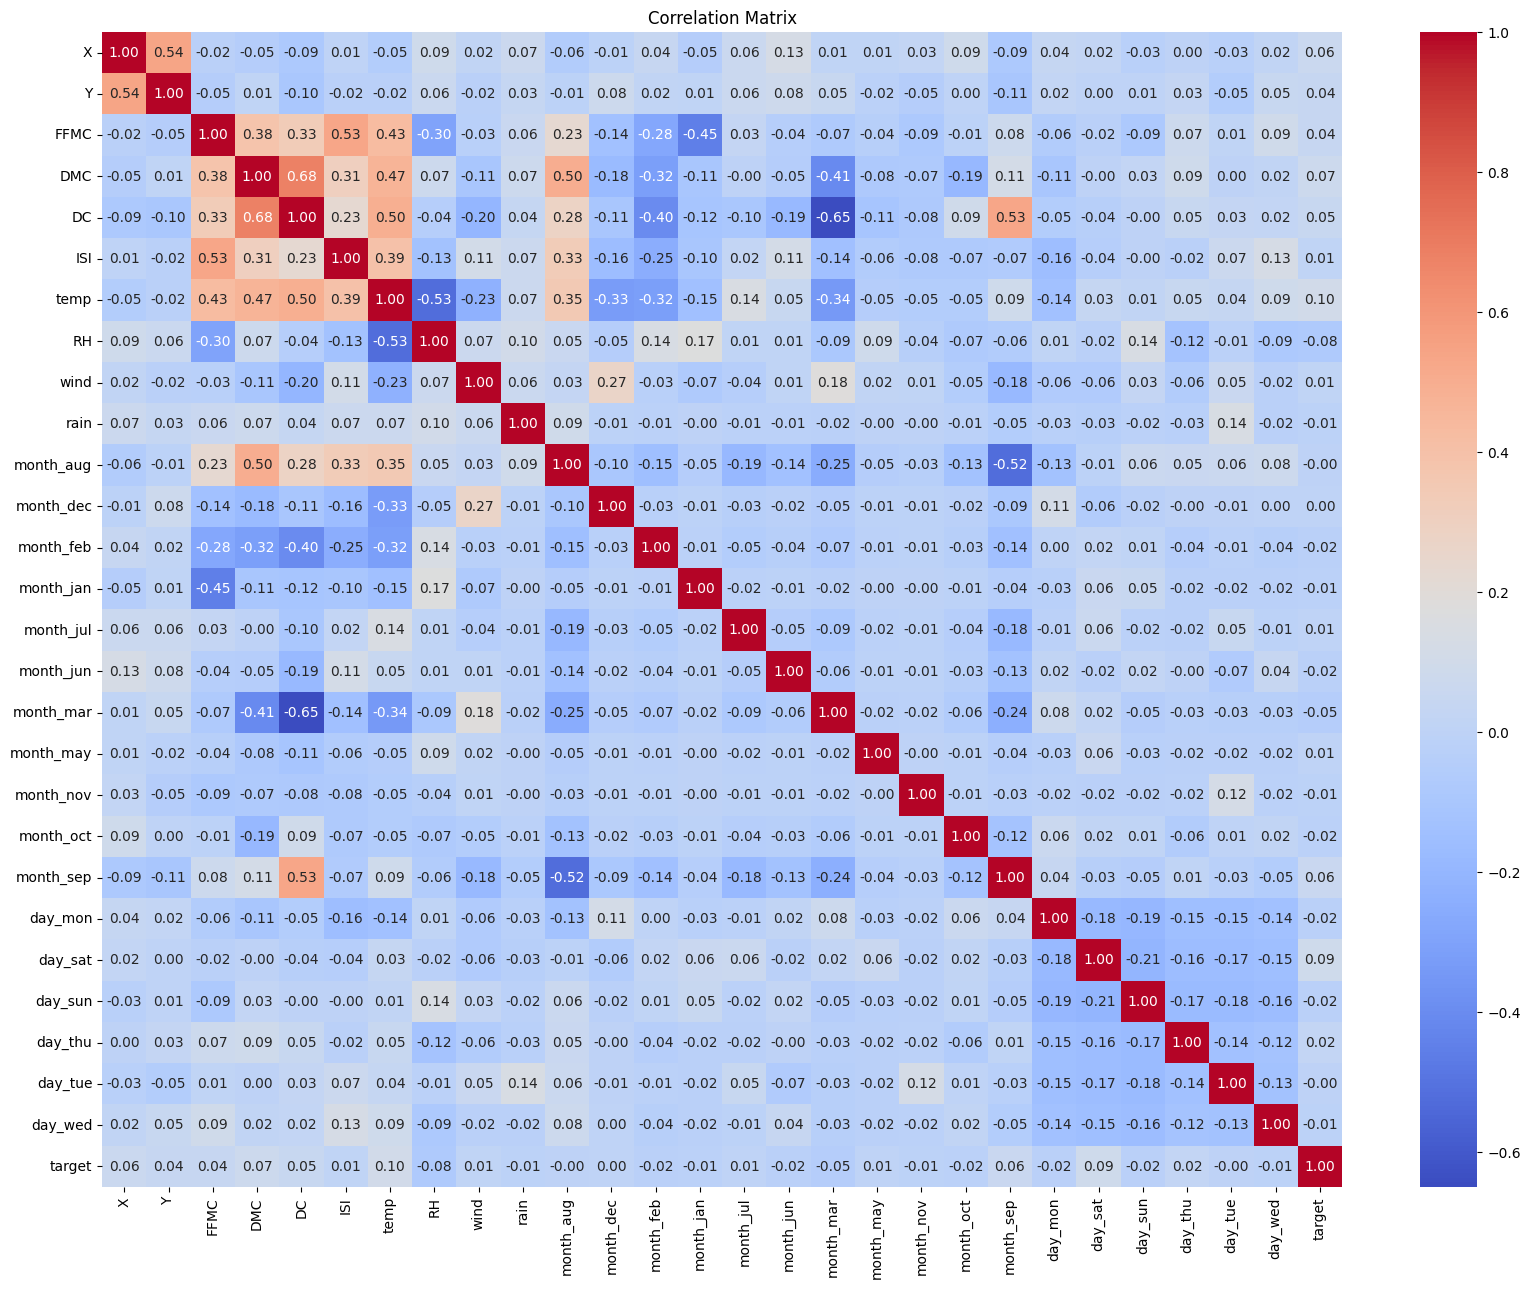

In [82]:
plt.figure(figsize=(20, 15))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

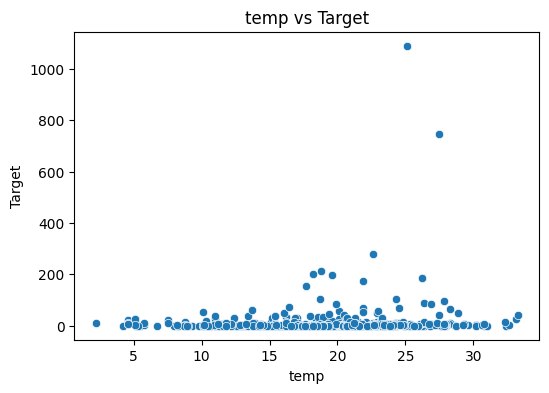

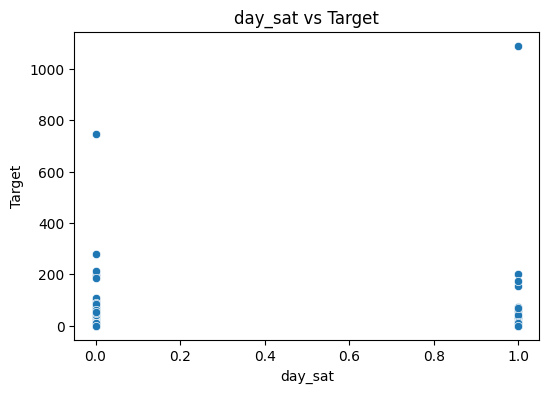

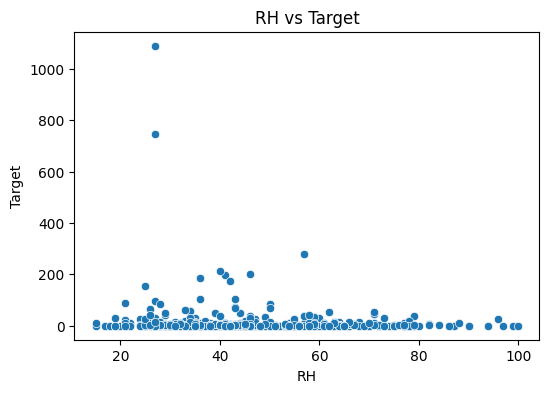

In [83]:
# Compute correlations on encoded data
corr_matrix = X_encoded.copy()
corr_matrix['target'] = y_1d
correlations = corr_matrix.corr()

# Get top 3 predictors most correlated with target
top_predictors = correlations['target'].abs().sort_values(ascending=False).index[1:4]

# Scatterplots
for predictor in top_predictors:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_encoded[predictor], y=y_1d)
    plt.title(f"{predictor} vs Target")
    plt.xlabel(predictor)
    plt.ylabel("Target")
    plt.show()

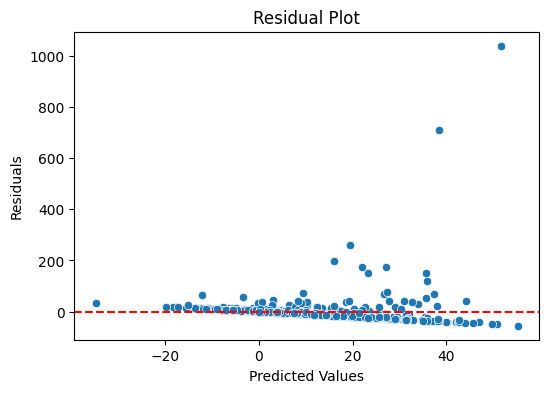

In [84]:
# Fit linear regression
model = LinearRegression()
model.fit(X_encoded, y)
y_pred = model.predict(X_encoded)
residuals = y - y_pred
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [93]:
# Keep only numeric columns
X_encoded = X_encoded.apply(pd.to_numeric, errors='coerce')

# Drop any non-numeric or NaN columns after conversion
X_encoded = X_encoded.dropna(axis=1, how='any')


# Add constant for intercept
X_with_const = sm.add_constant(X_encoded.astype(float))

vif = pd.DataFrame()
vif["Variable"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
              for i in range(X_with_const.shape[1])]

print(vif.sort_values("VIF"))

     Variable         VIF
10       rain    1.091537
19  month_nov    1.143729
18  month_may    1.265861
9        wind    1.283727
1           X    1.519055
2           Y    1.520045
27    day_wed    1.541806
14  month_jan    1.553586
25    day_thu    1.626784
26    day_tue    1.627844
22    day_mon    1.707381
23    day_sat    1.745808
6         ISI    1.815793
24    day_sun    1.821087
3        FFMC    2.283954
8          RH    2.801758
12  month_dec    2.958966
13  month_feb    3.172811
16  month_jun    3.708750
4         DMC    3.909533
7        temp    4.531085
17  month_mar    6.498128
20  month_oct    7.364374
15  month_jul    8.037860
5          DC   26.832445
11  month_aug   42.138727
21  month_sep   51.235905
0       const  742.744601


### Correlation analysis: find strongest predictors.
1. temp (0.098) → Positive relationship: higher temperature slightly increases burned area.

2. day_sat (0.088) → Fires tend to spread more on Saturdays (could be human activity).

3. DMC (0.073) → Duff Moisture Code, reflects dryness of fuel; higher values mean more fire spread.

4. Other variables like X, month_sep, DC also show weak but positive correlations.Notably, RH (-0.0755) is the strongest negative — higher humidity reduces fire spread.

### Multicollinearity check: Variance Inflation Factor (VIF).
#### VIF ≈ 1 → no multicollinearity (good).  VIF < 5 → generally acceptable. VIF between 5–10 → moderate multicollinearity (watch carefully). VIF > 10 → serious multicollinearity (should be addressed).

1. Safe predictors: rain, month_nov, wind, X, Y, ISI, FFMC, RH (all VIF < 5).

2. Moderate risk: temp (4.53), month_mar (6.5), month_oct (7.3), month_jul (8.0).

3. Severe multicollinearity:

       DC (26.8)

       month_aug (42.1)

       month_sep (51.2)

Feature engineering: quadratic terms, interactions, log transforms.

### Step 3: Fit the regression models

* Fit a baseline multiple linear regression model with key predictors.
* Include nonlinear terms (e.g., quadratic transformations for significant predictors).
* Add interaction terms (e.g., between predictors with strong correlations).
* Incorporate indicator variables if categorical variables are present.
* Apply transformations (e.g., logarithmic transformations for skewed predictors).

In [100]:
key_predictors = [
    "temp",      # strongest positive correlation
    "day_sat",   # categorical indicator
    "DMC",       # dryness index
    "X",         # spatial coordinate
    "RH",        # negative correlation (-0.0755)
    "wind",      # important for fire spread
    "rain"       # potential dampening effect
]
# Subset predictors
X_key = X_encoded[key_predictors]
X_key_const = sm.add_constant(X_key)

# Ensure predictors are numeric
X_key_const = X_key_const.astype(float)

# Fit baseline regression
baseline_model = sm.OLS(y_1d.astype(float), X_key_const).fit()

print(baseline_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.980
Date:                Sun, 21 Sep 2025   Prob (F-statistic):             0.0560
Time:                        15:48:33   Log-Likelihood:                -2873.5
No. Observations:                 517   AIC:                             5763.
Df Residuals:                     509   BIC:                             5797.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9900     21.688     -0.461      0.6

In [101]:
# Copy the key predictors
X_nonlinear = X_key.copy()

# Add quadratic terms
X_nonlinear['temp2'] = X_nonlinear['temp'] ** 2
X_nonlinear['DMC2'] = X_nonlinear['DMC'] ** 2

# Add constant
X_nonlinear_const = sm.add_constant(X_nonlinear).astype(float)

# Fit quadratic regression
quad_model = sm.OLS(y_1d.astype(float), X_nonlinear_const).fit()

print(quad_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.685
Date:                Sun, 21 Sep 2025   Prob (F-statistic):             0.0897
Time:                        15:54:57   Log-Likelihood:                -2872.8
No. Observations:                 517   AIC:                             5766.
Df Residuals:                     507   BIC:                             5808.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3902     27.790      0.302      0.7

In [102]:
# Start from nonlinear dataset
X_interact = X_nonlinear.copy()

# Add interaction terms
X_interact['temp_DMC'] = X_interact['temp'] * X_interact['DMC']
X_interact['temp_RH']  = X_interact['temp'] * X_interact['RH']

# Add constant
X_interact_const = sm.add_constant(X_interact).astype(float)

# Fit interaction model
interaction_model = sm.OLS(y_1d.astype(float), X_interact_const).fit()

print(interaction_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.590
Date:                Sun, 21 Sep 2025   Prob (F-statistic):             0.0981
Time:                        15:55:29   Log-Likelihood:                -2871.6
No. Observations:                 517   AIC:                             5767.
Df Residuals:                     505   BIC:                             5818.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.7777     48.313     -0.534      0.5

In [103]:
# Copy from interaction dataset
X_indicator = X_interact.copy()

# Create rain occurrence indicator (0 = no rain, 1 = some rain)
X_indicator['rain_occurrence'] = (X_indicator['rain'] > 0).astype(int)

# Add constant
X_indicator_const = sm.add_constant(X_indicator).astype(float)

# Fit the model
indicator_model = sm.OLS(y_1d.astype(float), X_indicator_const).fit()

print(indicator_model.summary())


                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.476
Date:                Sun, 21 Sep 2025   Prob (F-statistic):              0.129
Time:                        15:56:00   Log-Likelihood:                -2871.5
No. Observations:                 517   AIC:                             5769.
Df Residuals:                     504   BIC:                             5824.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -27.9230     48.538     

In [107]:
# Apply log transformation to the target (adding 1 to handle zeros)
y_log = np.log1p(y_1d)

# If you also want to transform a skewed predictor like 'DMC' or 'DC':
X_transformed = X_indicator.copy()
#X_transformed['log_DC'] = np.log1p(X_transformed['DC'])
X_transformed['log_DMC'] = np.log1p(X_transformed['DMC'])

# Add constant for regression
X_transformed_const = sm.add_constant(X_transformed).astype(float)

# Fit the log-transformed regression model
log_model = sm.OLS(y_log.astype(float), X_transformed_const).fit()

# Print summary
print(log_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.342
Date:                Sun, 21 Sep 2025   Prob (F-statistic):            0.00490
Time:                        15:58:36   Log-Likelihood:                -891.28
No. Observations:                 517   AIC:                             1811.
Df Residuals:                     503   BIC:                             1870.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.3035      1.350     

### Step 4: Evaluate model diagnostics

* Compare models using metrics like 2R^2, adjusted RR^2, AIC, and BIC.
* Plot residuals and create Q-Q plots to assess normality.
* Identify influential observations using Cook's Distance.

In [110]:
import statsmodels.api as sm


models = {
    'Baseline': baseline_model,
    'Quadratic': quad_model,
    'Interaction': interaction_model,
    'Log-Transformed': log_model
}

# Collect metrics
metrics = []
for name, model in models.items():
    metrics.append({
        'Model': name,
        'R-squared': model.rsquared,
        'Adjusted R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic
    })

metrics_df = pd.DataFrame(metrics).sort_values(by='Adjusted R-squared', ascending=False)
print(metrics_df)

             Model  R-squared  Adjusted R-squared          AIC          BIC
3  Log-Transformed   0.057073            0.032703  1810.555671  1870.028271
0         Baseline   0.026502            0.013114  5763.004571  5796.988914
2      Interaction   0.033467            0.012414  5767.292334  5818.268849
1        Quadratic   0.029045            0.011809  5765.652196  5808.132625


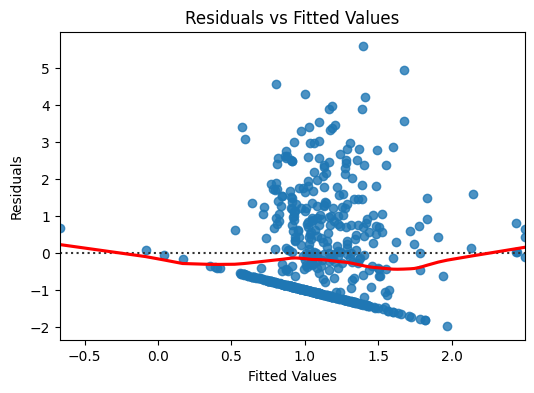

In [111]:
model = log_model  # replace with any model

residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(6,4))
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={"color": "red"})
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

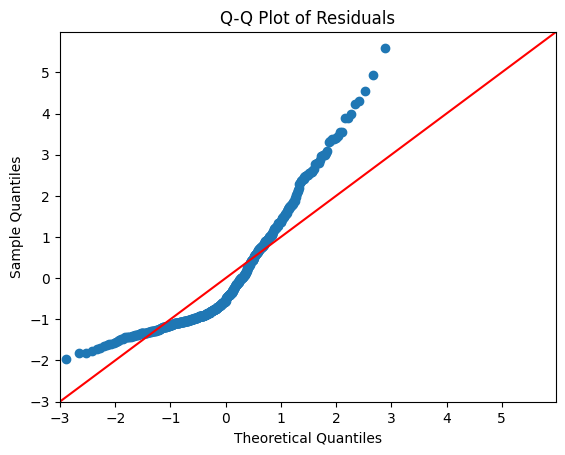

In [112]:
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

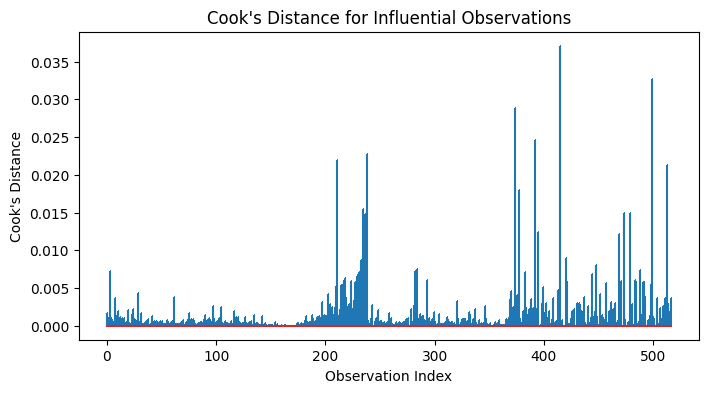

Influential observations (Cook's D > 4/n): [211 233 234 235 236 237 238 374 377 392 395 415 420 448 469 473 479 499
 513]


In [113]:
influence = model.get_influence()
cooks = influence.cooks_distance[0]

plt.figure(figsize=(8,4))
plt.stem(cooks, markerfmt=",", use_line_collection=True)
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance for Influential Observations")
plt.show()

# Optional: highlight influential points (commonly threshold = 4/n)
n = len(model.fittedvalues)
influential_points = np.where(cooks > 4/n)[0]
print("Influential observations (Cook's D > 4/n):", influential_points)

### Step 5: Apply regularization

* Use Ridge (L2) and Lasso (L1) regression from sklearn to handle multicollinearity.
* Extract coefficients and calculate Mean Squared Error (MSE).
* Compare the performance of Ridge and Lasso models.

### Step 6: Prepare the data for binary classification

* Create a binary target variable based on a threshold in y (e.g., median or other percentile).
* Select relevant predictors and scale them using StandardScaler.

### Step 7: Train and evaluate a logistic regression model

Train a logistic regression model using the scaled predictors.

* Display coefficients and the intercept.
* Predict probabilities and binary outcomes.
* Evaluate performance using accuracy, confusion matrix, precision, recall, and F1-score.

### Step 8: Check assumptions

* Use Variance Inflation Factor (VIF) to assess multicollinearity among predictors.

### Step 9: Summative Findings

* Compare regression models and classification results.
* Highlight trade-offs between model simplicity, performance, and interpretability.
* Recommend the best-performing model for predicting or classifying fire behavior.

[Type your findings here.]